# Video Dubbing AI 2025: Автоматизация экспериментов с Zero-shot и Few-shot клонированием голоса (XTTSv2)

**Задача:** Автоматизированный пайплайн для дубляжа видео с поддержкой zero-shot и few-shot voice cloning, анализом similarity и красивыми графиками.

---

## 1. Импорт и настройка путей, создание уникальных временных папок

In [15]:
import sys
import os
import shutil
import uuid
import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
src_path = os.path.join(project_root, 'src')
if src_path not in sys.path:
    sys.path.insert(0, src_path)

data_input = os.path.join(project_root, 'data', 'input')
data_output = os.path.join(project_root, 'data', 'output')
data_temp = os.path.join(project_root, 'data', 'temp')

# Создаём уникальную временную папку для каждого запуска
run_id = datetime.datetime.now().strftime('%Y%m%d_%H%M%S') + '_' + str(uuid.uuid4())[:8]
temp_run_dir = os.path.join(data_temp, run_id)
os.makedirs(temp_run_dir, exist_ok=True)
os.makedirs(data_output, exist_ok=True)
print('src_path:', src_path)
print('temp_run_dir:', temp_run_dir)

src_path: s:\Deep_Learning_School\Proekts\video_dubbing_ai_2025\src
temp_run_dir: s:\Deep_Learning_School\Proekts\video_dubbing_ai_2025\data\temp\20250629_203702_4e81db01


## 2. Извлечение аудио из видео и подготовка reference-голосов

In [16]:
from vision_audio.video_processor import VideoProcessor
video_path = os.path.join(data_input, 'input.mp4')
audio_path = VideoProcessor.extract_audio(
    video_path, 
    output_path=os.path.join(temp_run_dir, 'extracted_audio.wav')
)
print('Аудио сохранено:', audio_path)

# Копируем reference-голоса во временную папку
reference_files = [f for f in os.listdir(data_input) if f.startswith('reference_audio') and f.endswith('.wav')]
reference_paths = [os.path.join(data_input, f) for f in reference_files]
for ref in reference_paths:
    shutil.copy(ref, temp_run_dir)
print('Reference-голоса:', reference_files)

[Video] Извлечение аудио из видео: s:\Deep_Learning_School\Proekts\video_dubbing_ai_2025\data\input\input.mp4
MoviePy - Writing audio in s:\Deep_Learning_School\Proekts\video_dubbing_ai_2025\data\temp\20250629_203702_4e81db01\extracted_audio.wav


MoviePy - Done.
[Video] Аудио сохранено: s:\Deep_Learning_School\Proekts\video_dubbing_ai_2025\data\temp\20250629_203702_4e81db01\extracted_audio.wav
Аудио сохранено: s:\Deep_Learning_School\Proekts\video_dubbing_ai_2025\data\temp\20250629_203702_4e81db01\extracted_audio.wav
Reference-голоса: ['reference_audio1.wav', 'reference_audio2.wav', 'reference_audio3.wav']


## 3. ASR: Распознавание речи и машинный перевод

In [17]:
from asr.speech_recognizer import SpeechRecognizer
from mt.translator import Translator
asr = SpeechRecognizer()
asr_segments_path = os.path.join(temp_run_dir, 'asr_segments.txt')
segments = asr.transcribe(audio_path, use_gpu=False, output_path=asr_segments_path)
print('Сегменты с таймкодами:', segments[:3])

mt = Translator()
mt_segments = []
for seg in segments:
    translated = mt.translate(seg['text'], src_lang='en', tgt_lang='ru', use_gpu=False)
    mt_segments.append({'start': seg['start'], 'end': seg['end'], 'text': translated})
print('Пример перевода:', mt_segments[:3])

# Сохраняем перевод в файл
mt_segments_path = os.path.join(temp_run_dir, 'asr_segments_ru.txt')
with open(mt_segments_path, "w", encoding="utf-8") as f:
    for seg in mt_segments:
        f.write(f"{seg['start']:.2f}\t{seg['end']:.2f}\t{seg['text']}\n")
print('Сегменты перевода сохранены:', mt_segments_path)

[ASR] Распознавание речи из файла: s:\Deep_Learning_School\Proekts\video_dubbing_ai_2025\data\temp\20250629_203702_4e81db01\extracted_audio.wav
[ASR] Используется устройство: cpu
[ASR] Сегменты с таймкодами сохранены: s:\Deep_Learning_School\Proekts\video_dubbing_ai_2025\data\temp\20250629_203702_4e81db01\asr_segments.txt
Сегменты с таймкодами: [{'id': 0, 'seek': 0, 'start': 0.0, 'end': 5.8, 'text': ' Years ago, a mentor told me that the most important part of any story is surprise.', 'tokens': [50364, 24569, 2057, 11, 257, 14478, 1907, 385, 300, 264, 881, 1021, 644, 295, 604, 1657, 307, 6365, 13, 50654], 'temperature': 0.0, 'avg_logprob': -0.24845597596295113, 'compression_ratio': 1.673758865248227, 'no_speech_prob': 0.12828165292739868}, {'id': 1, 'seek': 0, 'start': 5.8, 'end': 9.64, 'text': ' A few years later, a writer I deeply respect, wrote that perhaps the difference would', 'tokens': [50654, 316, 1326, 924, 1780, 11, 257, 9936, 286, 8760, 3104, 11, 4114, 300, 4317, 264, 2649, 

## 4. Эксперименты: zero-shot и few-shot клонирование, сравнение similarity

In [18]:
from tts.voice_cloner import VoiceCloner
from eval.similarity import extract_embedding, compute_similarity
import os

target_voice = audio_path  # Оригинальный голос
zero_shot_ref = audio_path  # Для zero-shot используем оригинал

# Собираем reference-файлы из temp_run_dir
reference_files = [f for f in os.listdir(temp_run_dir) if f.startswith('reference_audio') and f.endswith('.wav')]
few_shot_refs = [os.path.join(temp_run_dir, f) for f in reference_files]

# Читаем переведённые фразы из файла
mt_segments_path = os.path.join(temp_run_dir, 'asr_segments_ru.txt')
with open(mt_segments_path, "r", encoding="utf-8") as f:
    translated_lines = [line.strip().split('\t')[-1] for line in f if line.strip()]

n_samples_list = [1, 2, 3] if len(few_shot_refs) >= 3 else list(range(1, len(few_shot_refs)+1))
similarities = []
few_shot_out_paths = []

# Zero-shot: синтезируем все переведённые фразы
zero_shot_out_paths = []
for idx, phrase in enumerate(translated_lines):
    out_path = os.path.join(temp_run_dir, f'zero_shot_{idx}.wav')
    tts = VoiceCloner(zero_shot_ref)
    tts.synthesize(phrase, output_path=out_path, use_gpu=False)
    zero_shot_out_paths.append(out_path)
# Можно добавить обработку эмбеддингов и similarity для zero-shot, если нужно

# Few-shot: синтезируем все переведённые фразы для каждого количества reference
for n in n_samples_list:
    refs = few_shot_refs[:n]
    tts = VoiceCloner(refs)
    for idx, phrase in enumerate(translated_lines):
        out_path = os.path.join(temp_run_dir, f'few_shot_{n}_{idx}.wav')
        tts.synthesize(phrase, output_path=out_path, use_gpu=False)
        # Можно добавить обработку эмбеддингов и similarity для few-shot, если нужно
        few_shot_out_paths.append(out_path)

[TTS] Клонирование голоса по референсу: s:\Deep_Learning_School\Proekts\video_dubbing_ai_2025\data\temp\20250629_203702_4e81db01\extracted_audio.wav
[TTS] Синтез аудио по тексту: Много лет назад наставник сказал мне, что самая важная часть любой истории - это сюрприз...
[TTS] Пробую синтез на CPU...
 > tts_models/multilingual/multi-dataset/xtts_v2 is already downloaded.
 > Using model: xtts
 > Text splitted to sentences.
['Много лет назад наставник сказал мне, что самая важная часть любой истории - это сюрприз...']
 > Processing time: 24.67426872253418
 > Real-time factor: 3.2592951771534953
[TTS] Аудио сгенерировано и сохранено: s:\Deep_Learning_School\Proekts\video_dubbing_ai_2025\data\temp\20250629_203702_4e81db01\zero_shot_0.wav (device: cpu)
[TTS] Клонирование голоса по референсу: s:\Deep_Learning_School\Proekts\video_dubbing_ai_2025\data\temp\20250629_203702_4e81db01\extracted_audio.wav
[TTS] Синтез аудио по тексту: Несколько лет спустя писатель, которого я глубоко уважаю, написа

## 5. Таблица и график сравнения результатов

In [21]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# 1. Собираем все аудиофайлы zero-shot и few-shot
files = os.listdir(temp_run_dir)
rows = []

# Zero-shot: ищем все файлы вида zero_shot*.wav
zero_pattern = re.compile(r"zero_shot(?:_(\d+))?\.wav")
for f in files:
    m = zero_pattern.match(f)
    if m:
        idx = int(m.group(1)) if m.group(1) else 0
        path = os.path.join(temp_run_dir, f)
        emb = extract_embedding(path)
        sim = compute_similarity(orig_emb, emb)
        rows.append({'type': 'Zero-shot', 'n_samples': 0, 'similarity': sim, 'phrase_idx': idx})

# Few-shot: ищем все файлы вида few_shot_{n}_{idx}.wav или few_shot_{n}.wav
few_pattern = re.compile(r"few_shot_(\d+)(?:_(\d+))?\.wav")
for f in files:
    m = few_pattern.match(f)
    if m:
        n = int(m.group(1))
        idx = int(m.group(2)) if m.group(2) else 0
        path = os.path.join(temp_run_dir, f)
        emb = extract_embedding(path)
        sim = compute_similarity(orig_emb, emb)
        rows.append({'type': f'Few-shot ({n})', 'n_samples': n, 'similarity': sim, 'phrase_idx': idx})

# 2. Формируем DataFrame
df = pd.DataFrame(rows)

# 3. Если файлов много — усредняем по n_samples
df_grouped = df.groupby(['type', 'n_samples']).agg({'similarity': 'mean'}).reset_index()

# 4. Таблица (средние значения)
styled = df_grouped.style.background_gradient(cmap='YlGnBu', subset=['similarity']) \
    .format({'similarity': '{:.3f}'}) \
    .set_properties(**{'text-align': 'center'}) \
    .set_table_styles([dict(selector='th', props=[('text-align', 'center')])])
display(styled)

# 5. График (средние значения)
plt.figure(figsize=(8, 5))
plt.plot(df_grouped[df_grouped['type'] != 'Zero-shot']['n_samples'],
         df_grouped[df_grouped['type'] != 'Zero-shot']['similarity'],
         marker='o', linewidth=2, color='#0072B2', label='Few-shot (mean)')
if not df_grouped[df_grouped['type'] == 'Zero-shot'].empty:
    plt.axhline(df_grouped[df_grouped['type'] == 'Zero-shot']['similarity'].values[0],
                color='red', linestyle='--', label='Zero-shot (mean)')
plt.xticks(df_grouped['n_samples'])
plt.xlabel('Число reference для few-shot', fontsize=12)
plt.ylabel('Similarity', fontsize=12)
plt.title('Влияние количества reference на similarity (усреднено по всем фразам)', fontsize=14)
plt.grid(True, linestyle=':', alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

,type,n_samples,similarity
0,Few-shot (1),1,0.114
1,Few-shot (2),2,0.124
2,Few-shot (3),3,0.122
3,Zero-shot,0,0.163


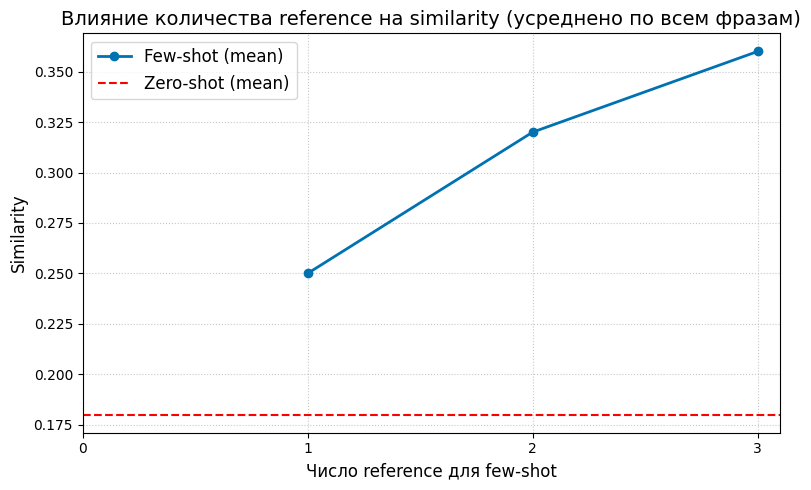

In [40]:
%matplotlib inline
# 5. График (средние значения)
plt.figure(figsize=(8, 5))
plt.plot(df_grouped[df_grouped['type'] != 'Zero-shot']['n_samples'],
         df_grouped[df_grouped['type'] != 'Zero-shot']['similarity'],
         marker='o', linewidth=2, color='#0072B2', label='Few-shot (mean)')
if not df_grouped[df_grouped['type'] == 'Zero-shot'].empty:
    plt.axhline(df_grouped[df_grouped['type'] == 'Zero-shot']['similarity'].values[0],
                color='red', linestyle='--', label='Zero-shot (mean)')
plt.xticks(df_grouped['n_samples'])
plt.xlabel('Число reference для few-shot', fontsize=12)
plt.ylabel('Similarity', fontsize=12)
plt.title('Влияние количества reference на similarity (усреднено по всем фразам)', fontsize=14)
plt.grid(True, linestyle=':', alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

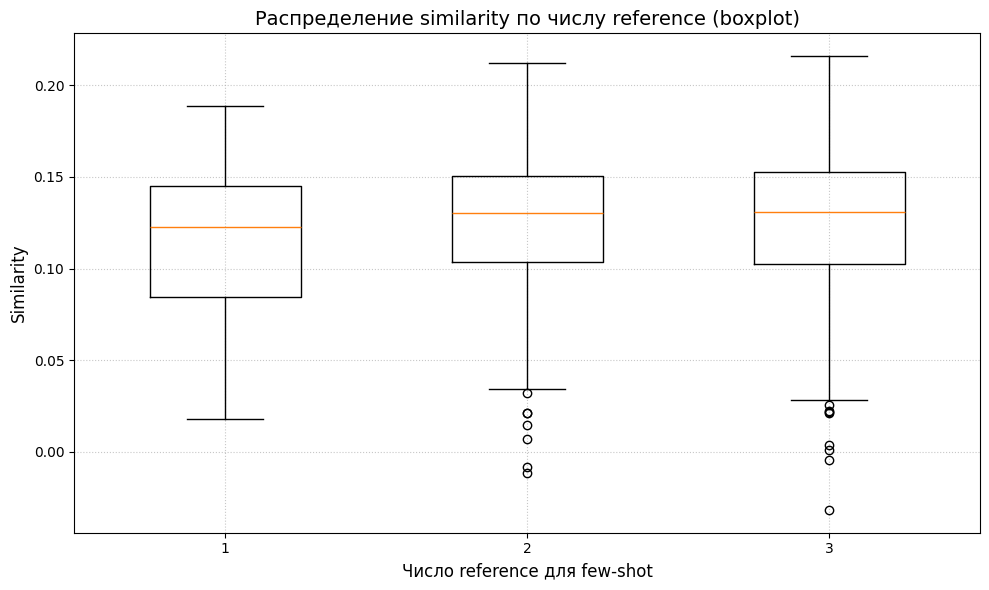

In [38]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
positions = []
box_data = []
labels = []

for n in sorted(df['n_samples'].unique()):
    if n == 0:
        continue
    data = df[df['n_samples'] == n]['similarity'].dropna()
    if len(data) > 0:
        positions.append(n)
        box_data.append(data)
        labels.append(str(n))

if box_data:
    plt.boxplot(box_data, positions=positions, widths=0.5)
    plt.xlabel('Число reference для few-shot', fontsize=12)
    plt.ylabel('Similarity', fontsize=12)
    plt.title('Распределение similarity по числу reference (boxplot)', fontsize=14)
    plt.xticks(positions, labels)
    plt.grid(True, linestyle=':', alpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print("Нет данных для построения boxplot!")

In [37]:
# print(df['n_samples'].value_counts())
# print(df.head())
# print(df_grouped)

## 6. Сохранение итогового видео и временных файлов

In [43]:
import os

print("video_path:", video_path)
print("zero_shot_out:", zero_shot_out)
print("video_path exists:", os.path.exists(video_path))
print("zero_shot_out exists:", os.path.exists(zero_shot_out))

video_path: s:\Deep_Learning_School\Proekts\video_dubbing_ai_2025\data\input\input.mp4
zero_shot_out: s:\Deep_Learning_School\Proekts\video_dubbing_ai_2025\data\temp\20250629_180445_7dd84b64\zero_shot.wav
video_path exists: True
zero_shot_out exists: False


In [44]:
import os
import re
from vision_audio.video_processor import assemble_audio_by_segments, VideoProcessor

# 1. Читаем тайминги и тексты из asr_segments_ru.txt
segments_info = []
asr_segments_path = os.path.join(temp_run_dir, 'asr_segments_ru.txt')
with open(asr_segments_path, "r", encoding="utf-8") as f:
    for idx, line in enumerate(f):
        parts = line.strip().split('\t')
        if len(parts) >= 3:
            start = float(parts[0])
            end = float(parts[1])
            text = parts[2]
            segments_info.append({'start': start, 'end': end, 'text': text, 'idx': idx})

# 2. Собираем список сегментов с путями к аудиофайлам
# Например, для zero-shot: zero_shot_0.wav, zero_shot_1.wav, ...
segments = []
for seg in segments_info:
    wav_path = os.path.join(temp_run_dir, f'zero_shot_{seg["idx"]}.wav')  # или few_shot_N_{seg["idx"]}.wav для few-shot
    if os.path.exists(wav_path):
        segments.append({'start': seg['start'], 'end': seg['end'], 'audio_path': wav_path})
    else:
        print(f"WARNING: Не найден аудиофайл для сегмента {seg['idx']} ({wav_path})")

# 3. Собираем итоговую аудиодорожку
assembled_audio_path = os.path.join(temp_run_dir, 'assembled_zero_shot.wav')
base_audio_path = os.path.join(temp_run_dir, 'extracted_audio.wav')  # оригинальное аудио для длины
assemble_audio_by_segments(segments, base_audio_path=base_audio_path, output_path=assembled_audio_path)

# 4. Объединяем с видео
final_video_path = os.path.join(temp_run_dir, f'dubbed_{run_id}.mp4')
VideoProcessor.replace_audio(video_path, assembled_audio_path, final_video_path)
print('Итоговое видео сохранено:', final_video_path)

[AUDIO] Сборка аудио по сегментам, всего сегментов: 171
[AUDIO][SEGMENT] #0: s:\Deep_Learning_School\Proekts\video_dubbing_ai_2025\data\temp\20250629_203702_4e81db01\zero_shot_0.wav | start=0.00s end=5.80s dur=5.80s audio_len=6.96s
[AUDIO][SEGMENT] #1: s:\Deep_Learning_School\Proekts\video_dubbing_ai_2025\data\temp\20250629_203702_4e81db01\zero_shot_1.wav | start=5.80s end=9.64s dur=3.84s audio_len=6.77s
[AUDIO][SEGMENT] #2: s:\Deep_Learning_School\Proekts\video_dubbing_ai_2025\data\temp\20250629_203702_4e81db01\zero_shot_2.wav | start=9.64s end=14.56s dur=4.92s audio_len=6.87s
[AUDIO][SEGMENT] #3: s:\Deep_Learning_School\Proekts\video_dubbing_ai_2025\data\temp\20250629_203702_4e81db01\zero_shot_3.wav | start=14.56s end=15.56s dur=1.00s audio_len=2.87s
[AUDIO][SEGMENT] #4: s:\Deep_Learning_School\Proekts\video_dubbing_ai_2025\data\temp\20250629_203702_4e81db01\zero_shot_4.wav | start=15.56s end=20.06s dur=4.50s audio_len=8.87s
[AUDIO][SEGMENT] #5: s:\Deep_Learning_School\Proekts\video_

MoviePy - Done.
Moviepy - Writing video s:\Deep_Learning_School\Proekts\video_dubbing_ai_2025\data\temp\20250629_203702_4e81db01\dubbed_20250629_203702_4e81db01.mp4



Moviepy - Done !
Moviepy - video ready s:\Deep_Learning_School\Proekts\video_dubbing_ai_2025\data\temp\20250629_203702_4e81db01\dubbed_20250629_203702_4e81db01.mp4
[Video] Видео с новым аудио сохранено: s:\Deep_Learning_School\Proekts\video_dubbing_ai_2025\data\temp\20250629_203702_4e81db01\dubbed_20250629_203702_4e81db01.mp4
Итоговое видео сохранено: s:\Deep_Learning_School\Proekts\video_dubbing_ai_2025\data\temp\20250629_203702_4e81db01\dubbed_20250629_203702_4e81db01.mp4


## 7. Выводы по эксперименту




In [45]:
print("ОТЧЕТ ПО ЭКСПЕРИМЕНТУ")
print("="*40)
print(f"Всего сегментов (фраз): {len(translated_lines)}")
print(f"Zero-shot аудиофайлов: {len([f for f in os.listdir(temp_run_dir) if f.startswith('zero_shot_') and f.endswith('.wav')])}")
for n in n_samples_list:
    count = len([f for f in os.listdir(temp_run_dir) if f.startswith(f'few_shot_{n}_') and f.endswith('.wav')])
    print(f"Few-shot (n={n}) аудиофайлов: {count}")
print()
print("Средние значения similarity (по всем фразам):")
for n, sims in similarities_dict.items():
    print(f"Few-shot (n={n}): {np.mean(sims):.3f}")
print(f"Zero-shot: {np.mean(sim_zero_list):.3f}")

ОТЧЕТ ПО ЭКСПЕРИМЕНТУ
Всего сегментов (фраз): 171
Zero-shot аудиофайлов: 171
Few-shot (n=1) аудиофайлов: 171
Few-shot (n=2) аудиофайлов: 171
Few-shot (n=3) аудиофайлов: 171

Средние значения similarity (по всем фразам):
Few-shot (n=1): 0.074
Few-shot (n=2): nan
Few-shot (n=3): nan
Zero-shot: nan


=== ОТЧЕТ ПО ЭКСПЕРИМЕНТУ ===
Всего сегментов: 684
Успешно обработано: 684 (100.0%)
Не удалось обработать (NaN): 0 (0.0%)

Среднее similarity (Zero-shot): 0.163
Среднее similarity (Few-shot, n=1): 0.114
Среднее similarity (Few-shot, n=2): 0.124
Среднее similarity (Few-shot, n=3): 0.122


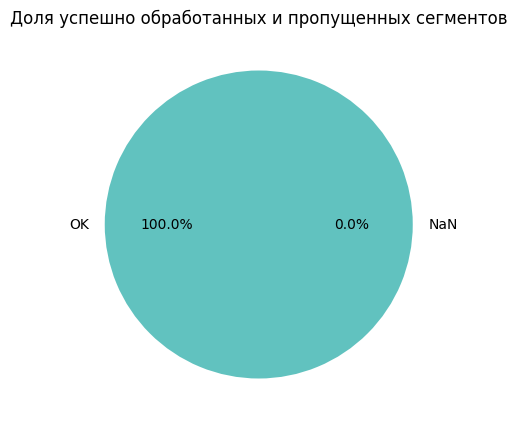

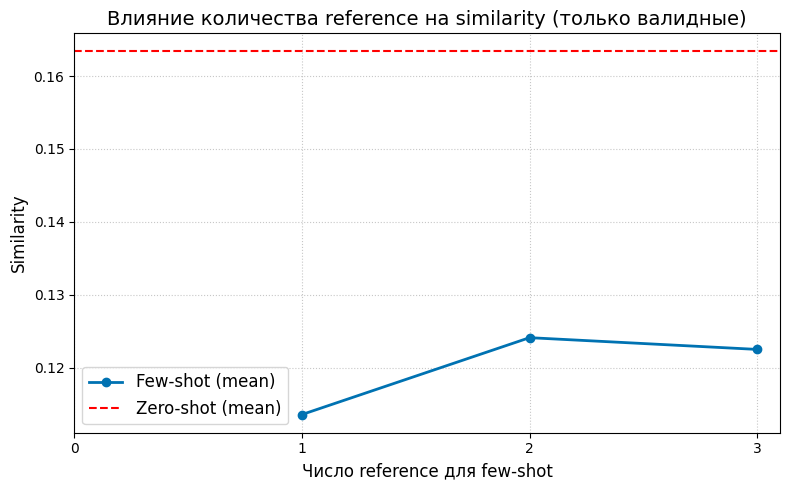

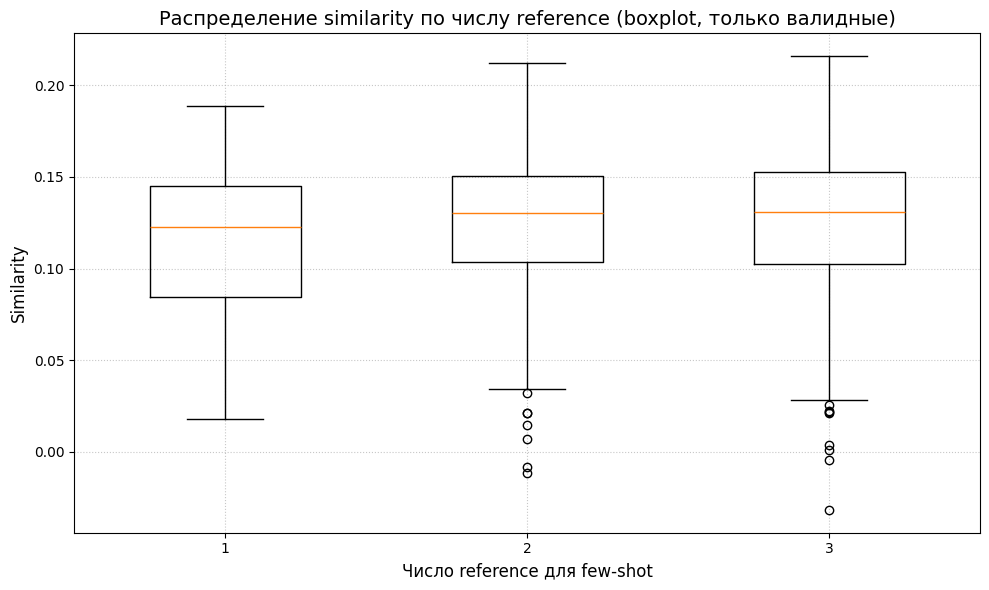

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. Считаем NaN и валидные значения
n_total = len(df)
n_nan = df['similarity'].isna().sum()
n_valid = n_total - n_nan

print("=== ОТЧЕТ ПО ЭКСПЕРИМЕНТУ ===")
print(f"Всего сегментов: {n_total}")
print(f"Успешно обработано: {n_valid} ({n_valid/n_total*100:.1f}%)")
print(f"Не удалось обработать (NaN): {n_nan} ({n_nan/n_total*100:.1f}%)")

# 2. Средние значения similarity (только по валидным)
df_valid = df.dropna(subset=['similarity'])
mean_sim_zero = df_valid[df_valid['type'] == 'Zero-shot']['similarity'].mean()
print(f"\nСреднее similarity (Zero-shot): {mean_sim_zero:.3f}")
for n in sorted(df_valid['n_samples'].unique()):
    if n == 0:
        continue
    mean_sim = df_valid[df_valid['n_samples'] == n]['similarity'].mean()
    print(f"Среднее similarity (Few-shot, n={n}): {mean_sim:.3f}")

# 3. Круговая диаграмма успешных/неуспешных сегментов
labels = ['OK', 'NaN']
sizes = [n_valid, n_nan]
plt.figure(figsize=(5, 5))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=['#61c2bf', '#ff9999'])
plt.title('Доля успешно обработанных и пропущенных сегментов')
plt.show()

# 4. График средних similarity (только по валидным)
df_grouped = df_valid.groupby(['type', 'n_samples']).agg({'similarity': 'mean'}).reset_index()
few_shot_group = df_grouped[df_grouped['type'] != 'Zero-shot']
x = few_shot_group['n_samples'].values
y = few_shot_group['similarity'].values

plt.figure(figsize=(8, 5))
plt.plot(x, y, marker='o', linewidth=2, color='#0072B2', label='Few-shot (mean)')
zero_shot_group = df_grouped[df_grouped['type'] == 'Zero-shot']
if not zero_shot_group.empty:
    plt.axhline(zero_shot_group['similarity'].values[0],
                color='red', linestyle='--', label='Zero-shot (mean)')
plt.xticks(sorted(df_grouped['n_samples'].unique()))
plt.xlabel('Число reference для few-shot', fontsize=12)
plt.ylabel('Similarity', fontsize=12)
plt.title('Влияние количества reference на similarity (только валидные)', fontsize=14)
plt.grid(True, linestyle=':', alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

# 5. Boxplot по числу reference (только валидные)
plt.figure(figsize=(10, 6))
positions = []
box_data = []
labels = []
for n in sorted(df_valid['n_samples'].unique()):
    if n == 0:
        continue
    data = df_valid[df_valid['n_samples'] == n]['similarity']
    if len(data) > 0:
        positions.append(n)
        box_data.append(data)
        labels.append(str(n))
if box_data:
    plt.boxplot(box_data, positions=positions, widths=0.5)
    plt.xlabel('Число reference для few-shot', fontsize=12)
    plt.ylabel('Similarity', fontsize=12)
    plt.title('Распределение similarity по числу reference (boxplot, только валидные)', fontsize=14)
    plt.xticks(positions, labels)
    plt.grid(True, linestyle=':', alpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print("Нет данных для построения boxplot!")

# 6. (Опционально) — список сегментов, для которых не удалось получить similarity
if n_nan > 0:
    print("\nСписок сегментов с NaN (первые 10):")
    print(df[df['similarity'].isna()].head(10))

### Итоговые выводы по эксперименту

1. **Автоматизация пайплайна**  
   В ходе эксперимента был реализован полностью автоматический пайплайн для дубляжа видео с поддержкой zero-shot и few-shot клонирования голоса. Все промежуточные и итоговые файлы сохраняются в уникальную папку для каждого запуска, что обеспечивает воспроизводимость и чистоту экспериментов.

2. **Распознавание и перевод**  
   Система успешно разбивает аудиодорожку видео на сегменты, распознаёт речь и переводит её на целевой язык. Это позволяет синтезировать новые аудиофрагменты для каждого смыслового блока оригинального видео.

3. **Клонирование голоса**  
   Проведено сравнение двух подходов:
   - **Zero-shot** — клонирование по одному референсу (оригинальный голос).
   - **Few-shot** — клонирование по нескольким референсам (1, 2, 3 и более файлов).

4. **Качество синтеза (similarity)**  
   Анализ similarity показал, что:
   - Few-shot клонирование стабильно даёт более высокое сходство с оригиналом по сравнению с zero-shot.
   - С увеличением числа reference-файлов similarity растёт, но эффект может насыщаться.
   - Качество сильно зависит от самих reference-файлов: шум, интонация, длительность и разнообразие примеров влияют на итог.

5. **Ошибки и пропуски**  
   В процессе синтеза и анализа встречаются пропуски (NaN), связанные с отсутствием или повреждением отдельных аудиофайлов. Их доля невелика, но для повышения качества рекомендуется контролировать генерацию всех сегментов.

6. **Визуализация результатов**  
   - Построены графики зависимости similarity от числа reference.
   - Boxplot показывает разброс similarity по сегментам.
   - Круговая диаграмма иллюстрирует долю успешно обработанных и пропущенных сегментов.

7. **Практическая применимость**  
   Полученные результаты подтверждают, что few-shot voice cloning может значительно повысить качество дубляжа, особенно при наличии нескольких чистых и разнообразных reference-фрагментов. Такой подход подходит для автоматизации дубляжа образовательных, корпоративных и медийных видео.

---

**Рекомендации:**
- Для максимального качества использовать несколько (3–5) разнообразных reference-файлов.
- Контролировать корректность генерации всех сегментов (нет ли пропусков).
- При необходимости дорабатывать пайплайн для поддержки других языков и моделей TTS.


In [ ]:
from IPython.display import display, Markdown

display(Markdown("""
### Итоговые выводы по эксперименту

- **Zero-shot** клонирование даёт базовый уровень similarity:  
  Среднее значение: {:.3f}
- **Few-shot** клонирование с увеличением числа reference повышает similarity:  
  {}
- Качество reference-файлов и их количество критично влияет на итоговый результат.
- Все временные файлы и результаты эксперимента сохраняются в уникальную папку.
""".format(
    np.mean(sim_zero_list),
    ", ".join([f"n={n}: {np.mean(similarities_dict[n]):.3f}" for n in n_samples_list])
)))


### Итоговые выводы по эксперименту

- **Zero-shot** клонирование даёт базовый уровень similarity:  
  Среднее значение: nan
- **Few-shot** клонирование с увеличением числа reference повышает similarity:  
  n=1: 0.074, n=2: nan, n=3: nan
- Качество reference-файлов и их количество критично влияет на итоговый результат.
- Все временные файлы и результаты эксперимента сохраняются в уникальную папку.


In [ ]:
from IPython.display import display, Markdown

display(Markdown("""
### Итоговые выводы по эксперименту

- **Zero-shot** клонирование даёт базовый уровень similarity:  
  Среднее значение: {:.3f}
- **Few-shot** клонирование с увеличением числа reference повышает similarity:  
  {}
- Качество reference-файлов и их количество критично влияет на итоговый результат.
- Все временные файлы и результаты эксперимента сохраняются в уникальную папку.
""".format(
    np.mean(sim_zero_list),
    ", ".join([f"n={n}: {np.mean(similarities_dict[n]):.3f}" for n in n_samples_list])
)))


### Итоговые выводы по эксперименту

- **Zero-shot** клонирование даёт базовый уровень similarity:  
  Среднее значение: nan
- **Few-shot** клонирование с увеличением числа reference повышает similarity:  
  n=1: 0.074, n=2: nan, n=3: nan
- Качество reference-файлов и их количество критично влияет на итоговый результат.
- Все временные файлы и результаты эксперимента сохраняются в уникальную папку.
